## Exploratory Data Analysis - WAKE AQUALAB MAY 2024 DATA

In [5]:
import json
import pickle
from matplotlib import animation
from matplotlib import pyplot as plt
import urllib
import os
import pandas as pd
import random
import lzma
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, TextVectorization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from math import isnan
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from collections import Counter
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### loading May 2024 raw event data

In [6]:
player_log_df = pd.read_csv('data_may_2024/raw/AQUALAB_20240501_to_20240531_7508479_events.tsv', sep='\t')

In [7]:
player_log_df.shape

(4336249, 14)

In [8]:
player_log_df.head()

,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
0,24050322155401459,AQUALAB,2024-05-04T05:16:05.529000+00:00,load_error,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",GAME,100,NaN,3,"-1 day, 23:59:34.800000",NaN,{},"{""job_name"": ""no-active-job""}",0
1,24050322155401459,AQUALAB,2024-05-04T05:16:05.545000+00:00,load_error,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",GAME,100,NaN,3,"-1 day, 23:59:34.800000",NaN,{},"{""job_name"": ""no-active-job""}",1
2,24050322155401459,AQUALAB,2024-05-04T05:16:05.579000+00:00,load_error,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",GAME,100,NaN,3,"-1 day, 23:59:34.800000",NaN,{},"{""job_name"": ""no-active-job""}",2
3,24050322155401459,AQUALAB,2024-05-04T05:16:14.559000+00:00,load_error,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",GAME,100,NaN,3,"-1 day, 23:59:34.800000",NaN,{},"{""job_name"": ""no-active-job""}",3
4,24050322155401459,AQUALAB,2024-05-04T05:16:14.560000+00:00,load_error,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",GAME,100,NaN,3,"-1 day, 23:59:34.800000",NaN,{},"{""job_name"": ""no-active-job""}",4


how many unique sessions

In [9]:
len(player_log_df.session_id.unique())

14095

number of unique player id

In [10]:
len(player_log_df.user_id.unique())

6273

number of unique events (not tasks)

In [11]:
len(player_log_df.event_name.unique())

54

different app branches

In [36]:
player_log_df.app_branch.value_counts(dropna=False)

app_branch
production                          3730055
production-has-savecode-reminder     298334
production-no-savecode-reminder      294560
NaN                                   11561
-no-savecode-reminder                   769
-has-savecode-reminder                  480
develop-no-savecode-reminder            227
develop-has-savecode-reminder            99
staging-no-savecode-reminder             96
develop                                  65
staging-has-savecode-reminder             3
Name: count, dtype: int64

extract job name from game state

In [13]:
import json

def extract_job_name(game_state_str):
  try:
    game_state = json.loads(game_state_str)
    return game_state.get('job_name', None)
  except (json.JSONDecodeError, AttributeError):
    return None

player_log_df['job_name'] = player_log_df['game_state'].apply(extract_job_name)

number of unique jobs

In [14]:
len(player_log_df['job_name'].unique())

55

In [15]:
N = 20
print(f"Top {N} JOBS")
player_log_df['job_name'].value_counts().sort_values(ascending=False)[:N]

Top 20 JOBS


job_name
no-active-job               1063200
kelp-welcome                 601706
arctic-missing-whale         227300
kelp-bull-kelp-forest        192087
kelp-shop-welcome            168126
kelp-energy                  158928
displaced-reef               114809
coral-fake-fix               107536
coral-hunting-lions           97434
coral-turtle-population       84990
arctic-salmon-monitoring      72110
kelp-mussel-fest              70197
bayou-shrimp-yields           66322
kelp-urchin-barren-viz        65036
bayou-alt-energy              64469
kelp-refuge-failure           63902
coral-stressed                58469
arctic-disappearing-act       58059
kelp-start-refuge             57642
arctic-endangered-seals       51936
Name: count, dtype: int64

In [16]:
N = 20
print(f"Top {N} EVENTS")
player_log_df['event_name'].value_counts().sort_values(ascending=False)[:N]

Top 20 EVENTS


event_name
script_line_displayed        1624027
script_fired                  456411
scene_changed                 304340
room_changed                  223679
receive_fact                  134568
add_critter                   122305
status_open_job_tab           109280
open_bestiary                 100956
close_bestiary                 94146
bestiary_select_species        70583
receive_entity                 66349
bestiary_open_species_tab      64083
complete_task                  58161
open_status                    54640
close_status                   54373
add_environment                53382
begin_experiment               51136
end_experiment                 50420
fact_submitted                 50009
switch_job                     49737
Name: count, dtype: int64

In [17]:
player_log_df[player_log_df["job_name"] == "no-active-job"].event_name.value_counts().sort_values(ascending=False)

event_name
script_line_displayed             531147
script_fired                      126568
scene_changed                     103399
room_changed                       94405
accept_job                         21661
receive_fact                       19622
receive_entity                     19187
switch_job                         19105
leave_argument                     17330
status_open_job_tab                13622
load_error                          9200
ask_for_help                        8672
begin_dive                          7450
add_critter                         7297
open_status                         6811
close_status                        6790
purchase_upgrade                    5657
open_bestiary                       5652
guide_script_triggered              4720
close_bestiary                      4535
bestiary_open_species_tab           4055
insufficient_funds                  2951
begin_experiment                    2835
model_phase_changed                 2818
add_e

let's get time taken to complete a job (`accept_job` to `complete_job`)

In [37]:
started_df = player_log_df[player_log_df["event_name"] == "accept_job"][["timestamp", "job_name", "user_id", "event_data", "app_branch"]].rename(columns={"timestamp":"timestamp_start"})
completed = player_log_df[player_log_df["event_name"] == "complete_job"][["timestamp", "job_name", "user_id", "event_data", "app_branch"]].rename(columns={"timestamp":"timestamp_end"})

In [38]:
json.loads(started_df['event_data'].values[0])

{'http_user_agent': 'Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36',
 'server_time': '2024-05-06T08:10:18+00:00'}

In [39]:
json.loads(completed['event_data'].values[0])

{'http_user_agent': 'Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
 'job_name': 'coral-casting-shade',
 'server_time': '2024-05-10T07:13:29+00:00'}

In [40]:
jobs_time = started_df.merge(completed, how="inner", on=["job_name", "user_id"])
jobs_time['delta_secs'] = (pd.to_datetime(jobs_time['timestamp_end']) - pd.to_datetime(jobs_time['timestamp_start'])).dt.total_seconds()
jobs_time

,timestamp_start,job_name,user_id,event_data_x,app_branch_x,timestamp_end,event_data_y,app_branch_y,delta_secs
0,2024-05-10T20:04:07.150000+00:00,arctic-cause-of-death,AbsentHair,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-12T21:34:58.325000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,178251.175
1,2024-05-10T19:16:22.272000+00:00,bayou-blue-waters,AdmiredTerm,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-30T18:43:38.625000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production-has-savecode-reminder,1726036.353
2,2024-05-21T16:55:28.929000+00:00,kelp-refuge-failure,AvengingSunset,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-22T14:05:45.316000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,76216.387
3,2024-05-05T17:25:44.309000+00:00,arctic-missing-whale,BinaryPiece,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-06T01:44:28.281000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,29923.972
4,2024-05-06T01:25:14.500000+00:00,arctic-missing-whale,BinaryPiece,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-06T01:44:28.281000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,1153.781
...,...,...,...,...,...,...,...,...,...
866,2024-05-01T19:44:06.245000+00:00,arctic-missing-whale,ThrilledTile,"{""http_user_agent"": ""Mozilla/5.0 (Windows NT 1...",production,2024-05-01T20:42:17.163000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (Windows NT 1...",production,3490.918
867,2024-05-01T12:39:02.689000+00:00,kelp-mussel-fest,WobblySocks,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-01T13:01:57.744000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,1375.055
868,2024-05-30T20:49:08.174000+00:00,arctic-missing-whale,InsultedWharf,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS aa...",production-has-savecode-reminder,2024-05-31T18:17:30.944000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS aa...",production-has-savecode-reminder,77302.770
869,2024-05-30T23:51:47.238000+00:00,arctic-isolated-instance,StackedPond,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production-has-savecode-reminder,2024-05-31T03:15:52.121000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production-has-savecode-reminder,12244.883


In [41]:
jobs_time.groupby('job_name').describe().sort_values(by=('delta_secs', 'mean'), ascending=False)

delta_secs                                \
                                    count           mean            std   
job_name                                                                  
coral-much-algae                      2.0  761225.758500       4.488007   
kelp-urchin-barren-predict            4.0  605524.489500  672780.471437   
coral-fishy-bizz                      4.0  593335.967000  551454.084875   
bayou-alt-energy                      7.0  558668.472143  664727.459059   
kelp-urchin-barren-viz                6.0  434035.653333  664663.746113   
coral-casting-shade                   9.0  428106.623333  630516.096597   
coral-turtle-stability                7.0  415406.678143  494540.618575   
arctic-in-ice                         9.0  406733.091667  257108.275094   
bayou-blue-waters                    20.0  298419.633150  622299.169106   
displaced-reef                       45.0  295186.813600  605876.686989   
turtle-danger2                        9.0  246871.104667  158562.519766   
above-n-below                         5.0  208732.627000  243795.949616   
coral-turtle-population              21.0  203933.012381  502313.455895   
arctic-disappearing-act               7.0  198104.968143  242846.298169   
bayou-oxygen-tracking                 5.0  196023.978000  267832.009557   
coral-hunting-lions                  16.0  194137.322188  184003.337554   
kelp-start-refuge                    11.0  190788.834909  241162.431636   
bayou-shrimp-yields                  39.0  186935.679103  258596.646595   
coral-ocean-plastics                  8.0  185562.334625  198474.691258   
coral-stressed                        9.0  182433.931444  209753.987527   
kelp-energy                          14.0  179044.915500  278530.833177   
arctic-endangered-seals              11.0  168284.026818  250566.604274   
arctic-cause-of-death                11.0  160525.793455  222387.531816   
kelp-musselfest-solution             22.0  158485.187773  312249.497092   
coral-fake-fix                       20.0  151801.364600  361256.598099   
arctic-missing-whale                403.0  147670.528633  280363.472396   
arctic-seal-habitats                  7.0  137791.557714  175098.685276   
bayou-boom-cause                      4.0  129647.524000  110511.424824   
turtle-danger                         7.0  123900.077857  222233.120028   
arctic-underneath                     9.0  122160.239889  192789.814919   
arctic-salmon-monitoring             30.0  119712.125167  382709.793651   
kelp-refuge-failure                  13.0  110139.691231  136030.713462   
kelp-mussel-fest                     29.0  107020.852690  193034.317847   
kelp-save-urchin-barren               3.0  104922.738333  164302.547421   
arctic-salmon-competition             5.0  100189.539400   96345.776977   
coral-eat-seaweed                     2.0   88448.329000  124840.474379   
arctic-isolated-instance              8.0   77619.703625  113134.320988   
bayou-shrimp-tastrophe                4.0   49731.716250   50423.684885   
arctic-stationary-survival            4.0   49650.680250   34171.017436   
arctic-time-of-death                  5.0   49237.409600  396005.839237   
bayou-hide-n-seek                     1.0   40849.770000            NaN   
kelp-urchin-farm                      5.0    6937.875000    8393.826253   
kelp-refuge-failure-simulation        1.0    1208.525000            NaN   
bayou-dirty-detritus                  1.0     228.925000            NaN   
coral-lionfish-conspiracy             9.0  -34821.275667  210688.377831   

                                                                       \
                                       min           25%          50%   
job_name                                                                
coral-much-algae                761222.585  761224.17175  761225.7585   
kelp-urchin-barren-predict         718.492   64794.57475  520536.6275   
coral-fishy-bizz                 36607.844  216923.94200  530348.

<Axes: >

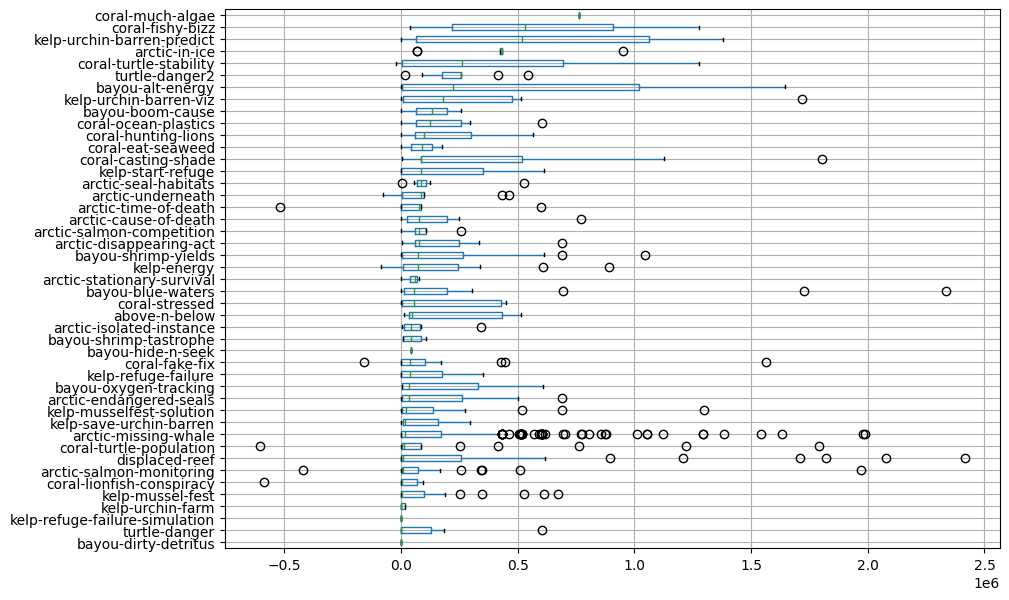

In [23]:
def boxplot_sorted(df, by, column, rot=0, **kwargs):
    # source: https://stackoverflow.com/questions/21912634/how-can-i-sort-a-boxplot-in-pandas-by-the-median-values/37871635#37871635
    
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes", **kwargs)

boxplot_sorted(jobs_time, column='delta_secs', by='job_name', vert=False, figsize=(10,7))

In [42]:
jobs_time[jobs_time["delta_secs"] < 0]

,timestamp_start,job_name,user_id,event_data_x,app_branch_x,timestamp_end,event_data_y,app_branch_y,delta_secs
12,2024-05-14T16:54:37.558000+00:00,arctic-time-of-death,ChillyPerch,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-08T17:06:45.770000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-517671.788
123,2024-05-09T17:30:55.454000+00:00,coral-turtle-population,ImmanentInfo,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-02T17:46:59.279000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-603836.175
139,2024-05-09T16:37:56.604000+00:00,kelp-energy,RavingFiesta,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-08T16:59:50.597000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-85086.007
259,2024-05-18T01:44:06.651000+00:00,coral-turtle-stability,KeyRhythm,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-17T19:37:18.183000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-22008.468
481,2024-05-28T14:31:02.278000+00:00,arctic-salmon-monitoring,ExaltedKnee,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-23T17:59:04.015000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-419518.263
489,2024-05-08T14:18:14.003000+00:00,arctic-underneath,SlantingOre,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-07T17:06:17.274000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-76316.729
490,2024-05-08T14:18:14.003000+00:00,arctic-underneath,SlantingOre,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-08T14:05:40.923000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-753.080
491,2024-05-08T16:48:05.502000+00:00,coral-fake-fix,SlantingOre,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-08T16:37:58.230000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-607.272
531,2024-05-16T13:23:26.513000+00:00,coral-lionfish-conspiracy,IntenseBeast,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,2024-05-09T18:19:53.620000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",production,-587012.893
670,2024-05-29T21:43:59.621000+00:00,coral-fake-fix,ImportedBayou,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",production-has-savecode-reminder,2024-05-29T21:28:15.795000+00:00,"{""http_user_agent"": ""Mozilla/5.0 (Macintosh; I...",production,-943.826


In [33]:
df_temp = player_log_df[(player_log_df.job_name == "arctic-time-of-death") & (player_log_df.user_id == "ChillyPerch") & (player_log_df["event_name"].isin(["accept_job", "complete_job", "switch_job"]))].sort_values(by="timestamp")
df_temp

,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index,job_name
1967605,24050710294292433,AQUALAB,2024-05-08T17:00:14.660000+00:00,switch_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",GAME,100,production,3,"-1 day, 23:59:42",ChillyPerch,{},"{""current_bestiary"": ""[\""WarmKelpForest\"",\""Ur...",1956,arctic-time-of-death
1967697,24050710294292433,AQUALAB,2024-05-08T17:06:45.770000+00:00,complete_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",GAME,100,production,3,"-1 day, 23:59:42",ChillyPerch,{},"{""job_name"": ""arctic-time-of-death""}",2048,arctic-time-of-death
70776,24051409140663533,AQUALAB,2024-05-14T16:50:45.170000+00:00,switch_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",GAME,100,production,3,"-1 day, 23:59:42",ChillyPerch,{},"{""current_bestiary"": ""[\""WarmKelpForest\"",\""Ur...",399,arctic-time-of-death
3508513,24051411521129739,AQUALAB,2024-05-14T16:52:45.871000+00:00,switch_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",GAME,100,production,3,"-1 day, 23:59:42",ChillyPerch,{},"{""current_bestiary"": ""[\""WarmKelpForest\"",\""Ur...",1,arctic-time-of-death
70887,24051409140663533,AQUALAB,2024-05-14T16:54:37.558000+00:00,accept_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",GAME,100,production,3,"-1 day, 23:59:42",ChillyPerch,{},"{""job_name"": ""arctic-time-of-death""}",510,arctic-time-of-death
3508588,24051411521129739,AQUALAB,2024-05-14T16:58:08.589000+00:00,complete_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",GAME,100,production,3,"-1 day, 23:59:42",ChillyPerch,{},"{""job_name"": ""arctic-time-of-death""}",76,arctic-time-of-death


In [35]:
for l in df_temp["event_data"].values:
    print(l)

{"http_user_agent": "Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36", "prev_job_name": "no-active-job", "server_time": "2024-05-08T12:00:15+00:00"}
{"http_user_agent": "Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36", "job_name": "arctic-time-of-death", "server_time": "2024-05-08T12:06:52+00:00"}
{"http_user_agent": "Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36", "prev_job_name": "no-active-job", "server_time": "2024-05-14T11:50:45+00:00"}
{"http_user_agent": "Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36", "prev_job_name": "no-active-job", "server_time": "2024-05-14T11:53:02+00:00"}
{"http_user_agent": "Mozilla/5.0 (X11; CrOS x86_64 14541.0.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36", "server_time": "

### loading May 2024 detected event data

In [ ]:
detected_df = pd.read_csv('data_may_2024/detectors/AQUALAB_20240501_to_20240531_7508479_all-events.tsv', sep='\t')

In [ ]:
detected_df.shape

(4336249, 14)

check if detectors added new rows

In [ ]:
detected_df.equals(player_log_df)

True

nope, detectors don't add new info

### loading May 2024 features data

In [2]:
population_features_df = pd.read_csv('data_may_2024/features/population/AQUALAB_20240501_to_20240531_7508479_population-features.tsv', sep='\t')
player_features_df = pd.read_csv('data_may_2024/features/player/AQUALAB_20240501_to_20240531_7508479_player-features.tsv', sep='\t')
session_features_df = pd.read_csv('data_may_2024/features/session/AQUALAB_20240501_to_20240531_7508479_session-features.tsv', sep='\t')

print("Shapes:")
print("Population", population_features_df.shape)
print("Player", player_features_df.shape)
print("Session", session_features_df.shape)

Shapes:
Population (1, 839)
Player (6273, 906)
Session (14817, 846)


In [3]:
population_features_df.head()

,PlayerCount,SessionCount,ActiveJobs,AppVersions,JobsCompleted,JobsCompleted-Names,SessionDiveSitesCount,SwitchJobsCount,TotalArgumentationTime,TotalArgumentationTime-Seconds,...,job53_SyncCompletionTime,job54_SyncCompletionTime,job55_SyncCompletionTime,job56_SyncCompletionTime,job57_SyncCompletionTime,job58_SyncCompletionTime,job59_SyncCompletionTime,job60_SyncCompletionTime,UserAvgSessionDuration,UserTotalSessionDuration
0,6272,14095,"{\kelp-welcome\"": [\""AbruptCore\"", \""AcidicWhe...","[""100"", ""0"", ""101"", ""62"", ""81""]",0,[],13,49737,"509 days, 23:18:02.215000",4.406148e+07,...,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0,0.0


In [4]:
player_features_df.head()

,PlayerID,SessionCount,ActiveJobs,AppVersions,JobsCompleted,JobsCompleted-Names,SessionDiveSitesCount,SwitchJobsCount,TotalArgumentationTime,TotalArgumentationTime-Seconds,...,job59_SyncCompletionTime,job60_SyncCompletionTime,TotalPlayTime,TotalPlayTime-Seconds,TotalPlayTime-Active,TotalPlayTime-Active - Seconds,TotalPlayTime-Idle,TotalPlayTime-Idle - Seconds,UserAvgSessionDuration,UserTotalSessionDuration
0,NaN,950,{},"[""100"", ""101"", ""62""]",0,[],0,0,0:00:00,0.000,...,0:00:00,0:00:00,"1 day, 9:05:28.402000",0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,123.449121,119128.402
1,AbruptCore,1,"{\kelp-welcome\"": [\""AbruptCore\""]}""","[""100""]",0,[],0,1,0:00:00,0.000,...,0:00:00,0:00:00,0:02:21.044000,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,141.044000,141.044
2,AbsentHair,11,"{\arctic-seal-habitats\"": [\""AbsentHair\""], \""...","[""100""]",32,"[""coral-casting-shade"", ""coral-much-algae"", ""c...",8,71,2:24:58.004000,8698.004,...,0:00:00,0:00:00,"1 day, 0:11:49.386000",0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,7919.035091,87109.386
3,AbsentSled,1,"{\no-active-job\"": [\""AbsentSled\""]}""","[""100""]",4,"[""kelp-welcome"", ""kelp-bull-kelp-forest"", ""kel...",2,8,0:01:31.283000,91.283,...,0:00:00,0:00:00,0:26:57.005000,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,1617.005000,1617.005
4,AbsoluteLeaf,6,"{\arctic-endangered-seals\"": [\""AbsoluteLeaf\""...","[""101""]",25,"[""kelp-urchin-barren-predict"", ""coral-stressed...",12,56,"-1 day, 22:54:51.741000",-3908.259,...,0:00:00,0:00:00,7:21:37.554000,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,4416.259000,26497.554


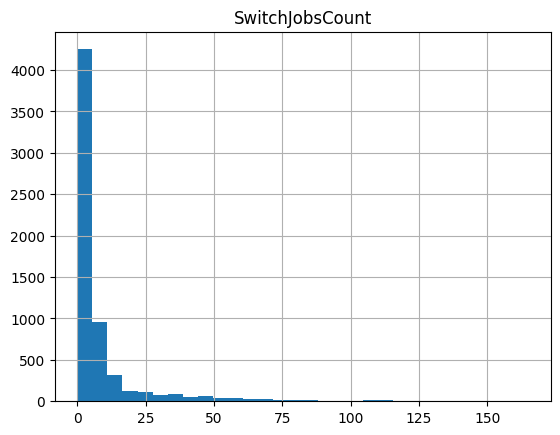

In [5]:
player_features_df.SwitchJobsCount.hist(bins=30)
plt.title("SwitchJobsCount");

In [6]:
session_features_df.head()

,PlayerID,SessionID,ActiveJobs,AppVersions,JobsCompleted,JobsCompleted-Names,SessionDiveSitesCount,SessionDuration,SessionDuration-Total,SessionDuration-Seconds,...,job53_SyncCompletionTime,job54_SyncCompletionTime,job55_SyncCompletionTime,job56_SyncCompletionTime,job57_SyncCompletionTime,job58_SyncCompletionTime,job59_SyncCompletionTime,job60_SyncCompletionTime,UserAvgSessionDuration,UserTotalSessionDuration
0,NaN,24050322155401459,{},"[""100""]",0,[],0,0:00:09.080000,9.080,0:00:09.080000,...,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,9.080,9.080
1,NaN,24050408403943819,{},"[""100""]",0,[],0,0:00:00,0.000,0:00:00,...,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0.000,0.000
2,NaN,24050411333095285,{},"[""100""]",0,[],0,0:00:00,0.000,0:00:00,...,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0.000,0.000
3,NaN,24050608472711739,{},"[""100""]",0,[],0,0:00:00.003000,0.003,0:00:00.003000,...,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0.003,0.003
4,NaN,24050609020367835,{},"[""100""]",0,[],0,0:00:54.291000,54.291,0:00:54.291000,...,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,54.291,54.291


In [7]:
session_features_df.columns.values

array(['PlayerID', 'SessionID', 'ActiveJobs', 'AppVersions',
       'JobsCompleted', 'JobsCompleted-Names', 'SessionDiveSitesCount',
       'SessionDuration', 'SessionDuration-Total',
       'SessionDuration-Seconds', 'SessionDuration-Active',
       'SessionDuration-ActiveSeconds', 'SessionDuration-IdleIdleSeconds',
       'SessionDuration-MaxIdle', 'SwitchJobsCount',
       'TotalArgumentationTime', 'TotalArgumentationTime-Seconds',
       'TotalArgumentationTime-Active',
       'TotalArgumentationTime-Active-Seconds',
       'TotalArgumentationTime-Idle',
       'TotalArgumentationTime-Idle-Seconds', 'TotalDiveTime',
       'TotalDiveTime-Seconds', 'TotalDiveTime-Active',
       'TotalDiveTime-Active-Seconds', 'TotalDiveTime-Idle',
       'TotalDiveTime-Idle-Seconds', 'TotalExperimentationTime',
       'TotalExperimentationTime-Seconds',
       'TotalExperimentationTime-Active',
       'TotalExperimentationTime-Active-Seconds',
       'TotalExperimentationTime-Idle',
       'TotalEx

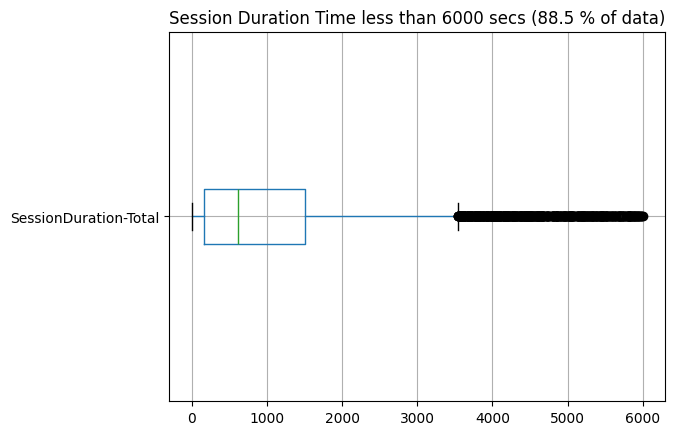

In [8]:
filter_sec = session_features_df["SessionDuration-Total"] < 6000
session_features_df[filter_sec].boxplot(column="SessionDuration-Total", vert=False)
plt.title(f"Session Duration Time less than 6000 secs ({round(100 * filter_sec.sum()/session_features_df.shape[0], 2)} % of data)");

In [14]:
import plotly.express as px
import re

corr = session_features_df[[col for col in session_features_df.columns if not re.search(r'\d', col) and col != "SessionID"]].corr(numeric_only=True)

fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu',
    title='Correlation Heatmap: Session Durations',
    labels=dict(color='Correlation'),
    aspect='auto'
)
fig.show()

**Questions:**
- what events David used in events.csv?
- what is the `nan` user id? **BEFORE GAME STARTED**
- If a player starts a new game, would it have the same user_id? **NO**
- why there are negative times of job completion (like in `coral-lionfish-conspiracy`)? **CHECK CODE, in case people return to the same task later**
- detectors dataframe is the same as raw events
- would it be relevant to build a graph with weighted connections of how people manage the order of jobs completion?